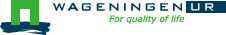

# Optimizing parameters in a PCSE crop model

In this Jupyter notebook we will use a set of synthetic observations of LAI to optimize the TWDI (total initial dry weight) and SPAN (life span of leaves) parameters of the PCSE/WOFOST model using an optimization algorithm. 

Allard de Wit, January 2018 (allard.dewit@wur.nl)


## First some relevant imports

In [5]:
%matplotlib inline
from __future__ import print_function
import sys
import matplotlib
matplotlib.style.use("ggplot")
import matplotlib.pyplot as plt
import yaml
import pandas as pd
import numpy as np
import nlopt

import pcse
from pcse.models import Wofost71_PP
from pcse.base_classes import ParameterProvider
from pcse.db import NASAPowerWeatherDataProvider
from pcse.fileinput import YAMLAgroManagementReader, YAMLCropDataProvider
from pcse.util import WOFOST71SiteDataProvider, DummySoilDataProvider
print("This notebook was built with:")
print("python version: %s " % sys.version)
print("PCSE version: %s" %  pcse.__version__)

This notebook was built with:
python version: 2.7.14 |Anaconda, Inc.| (default, Nov  8 2017, 13:40:13) [MSC v.1500 32 bit (Intel)] 
PCSE version: 5.3.1


## Collect necessary input data for WOFOST

In [6]:
# Weather data for Netherlands
wdp = NASAPowerWeatherDataProvider(latitude=52, longitude=5)
# Standard crop parameter library
cropd = YAMLCropDataProvider()
# We don't need soil for potential production, so we use dummy values
soild = DummySoilDataProvider()
# Some site parameters
sited = WOFOST71SiteDataProvider(WAV=50, CO2=360.)
# Package everyting into a single parameter object
params = ParameterProvider(cropdata=cropd, sitedata=sited, soildata=soild)

In [7]:
# Here we define the agromanagement for sugar beet
agro_yaml = """
- 2006-01-01:
    CropCalendar:
        crop_name: sugarbeet
        variety_name: Sugarbeet_603
        crop_start_date: 2006-03-31
        crop_start_type: emergence
        crop_end_date: 2006-10-20
        crop_end_type: harvest
        max_duration: 300
    TimedEvents: null
    StateEvents: null
"""
agro = yaml.load(agro_yaml)

# Run the simulation with the default parameters
We use the standard WOFOST output as pseudo observations, so first we run the model with the default crop parameters and collect the output.

In [8]:
wofost = Wofost71_PP(params, wdp, agro)
wofost.run_till_terminate()
df = pd.DataFrame(wofost.get_output())
df.index = pd.to_datetime(df.day)
df.tail()

,DVS,LAI,RD,SM,TAGP,TRA,TWLV,TWRT,TWSO,TWST,WWLOW,day
day,,,,,,,,,,,,
2006-10-16,2.220936,1.265844,120.0,0.3,24726.216999,0.093676,4789.674289,3802.967224,15107.188757,4829.353952,None,2006-10-16
2006-10-17,2.226857,1.274199,120.0,0.3,24809.763246,0.091826,4793.851602,3804.672249,15182.380380,4833.531264,None,2006-10-17
2006-10-18,2.233179,1.257153,120.0,0.3,24889.247552,0.065323,4797.825817,3806.294378,15253.916255,4837.505480,None,2006-10-18
2006-10-19,2.241614,1.257496,120.0,0.3,24892.672105,0.073979,4797.997045,3806.364267,15256.998353,4837.676707,None,2006-10-19
2006-10-20,2.250150,1.234992,120.0,0.3,24924.502678,0.071356,4799.588573,3807.013870,15285.645869,4839.268236,None,2006-10-20


## Sample the WOFOST output to generate some "observations"
Let's assume that we have weekly field observations of LAI, therefore we resample the dataframe with WOFOST output.

Text(0.5,1,u'Pseudo LAI observations')

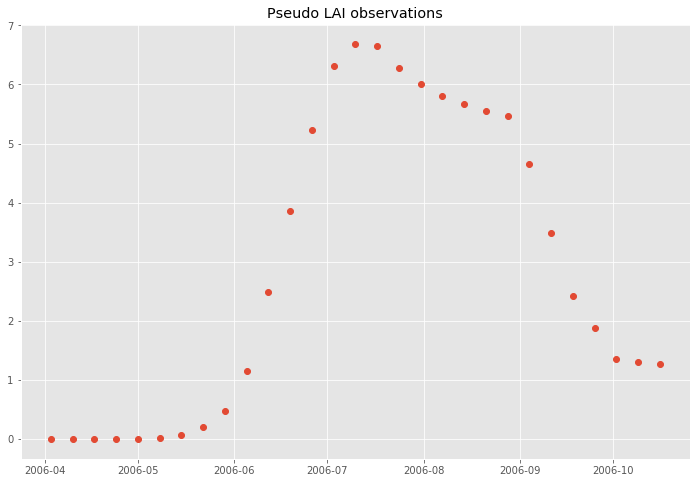

In [9]:
# get daily observations for those
ix = (df.index.dayofweek == 0) & (df.LAI.notnull())
df_pseudo_obs = df.loc[ix]
fig, axes = plt.subplots(figsize=(12,8))
axes.plot_date(df_pseudo_obs.index, df_pseudo_obs.LAI)
axes.set_title("Pseudo LAI observations")

## Define a model runner
A model runner just reruns the WOFOST model with different values for a set of parameters, in this case "TDWI" and "SPAN". It then collects the model output, converts it to a dataframe and returns it. 

Changing the model parameters for each WOFOST simulation is done with the `set_override()` method on the parameter object.

In [10]:
class ModelRerunner(object):
    """Reruns a given model with different values of parameters TWDI and SPAN.
    
    Returns a pandas DataFrame with simulation results of the model with given
    parameter values.
    """
    parameters = ["TDWI", "SPAN"]
    
    def __init__(self, params, wdp, agro):
        self.params = params
        self.wdp = wdp
        self.agro = agro
        
    def __call__(self, par_values):
        # Check if correct number of parameter values were provided
        if len(par_values) != len(self.parameters):
            msg = "Optimizing %i parameters, but only % values were provided!" % (len(self.parameters, len(par_values)))
            raise RuntimeError(msg)
        # Clear any existing overrides
        self.params.clear_override()
        # Set overrides for the new parameter values
        for parname, value in zip(self.parameters, par_values):
            self.params.set_override(parname, value)
        # Run the model with given parameter values
        wofost = Wofost71_PP(self.params, self.wdp, self.agro)
        wofost.run_till_terminate()
        df = pd.DataFrame(wofost.get_output())
        df.index = pd.to_datetime(df.day)
        return df

## Define an object function calculator
The objective function calculator runs the WOFOST model with the given set of input parameters, collects the simulation results and computes the differences with the observations. Different objective functions can be used, in this case we use the root of the mean squared error (RMSE).

In [11]:
class ObjectiveFunctionCalculator(object):
    """Computes the objective function.
    
    This class runs the simulation model with given parameter values and returns the objective
    function as the sum of squared difference between observed and simulated LAI.
.   """
    
    def __init__(self, params, wdp, agro, observations):
        self.modelrerunner = ModelRerunner(params, wdp, agro)
        self.df_observations = observations
        self.n_calls = 0
       
    def __call__(self, par_values, grad=None):
        """Runs the model and computes the objective function for given par_values.
        
        The input parameter 'grad' must be defined in the function call, but is only
        required for optimization methods where analytical gradients can be computed.
        """
        self.n_calls += 1
        print(".", end="")
        # Run the model and collect output
        self.df_simulations = self.modelrerunner(par_values)
        # compute the differences by subtracting the DataFrames
        # Note that the dataframes automatically join on the index (dates) and column names
        df_differences = self.df_simulations - self.df_observations
        # Compute the RMSE on the LAI column
        obj_func = np.sqrt(np.mean(df_differences.LAI**2))
        return obj_func

## Test the objective function calculator
The objective function calculator should return a value of zero when called with the default 
values of TWDI and SPAN.

In [12]:
objfunc_calculator = ObjectiveFunctionCalculator(params, wdp, agro, df_pseudo_obs)
defaults = [cropd["TDWI"], cropd["SPAN"]]
error = objfunc_calculator(defaults)
print("Error with default parameters (%s): %s" % (defaults, error))

.Error with default parameters ([0.51, 37.0]): 0.0


## Let's try to find the optimum by brute force
We will now find the optimum by simply trying combinations of TDWI/SPAN across a grid in certain step sizes. Of course in reality we do not know where the true value is and you may need to make the step size smaller. Note that with small step sizes, the number of function calls increases quadratically and this approach becomes impractical.

With the current example, we do not reach an error of zero because with our default stepsize (0.02) TWDI does not hit the true value (0.51).

In [13]:
lowest_error = 99999
best_values = None
stepsize1 = 0.02
stepsize2 = 1.
for p1 in np.arange(0.4, 0.6, stepsize1):
    for p2 in np.arange(30, 40, stepsize2):
        error = objfunc_calculator([p1, p2])
        if error <  lowest_error:
            best_values = [p1, p2]
            lowest_error = error
print("\nLowest error (%s) with values: %s" % (lowest_error, best_values))
            

....................................................................................................
Lowest error (0.011729883932679024) with values: [0.5200000000000001, 37.0]


## Try to do smart optimization: use NLOPT
the NLOPT library provides many algorithms for numerical optimization. We use NLOPT a lot for optimization of crop simulation models but only the global search algorithms (the 'GN' algorithms) and the local search algorithms that do not require analytical gradients (the 'LN' algorithms) because computing analytical gradients on crop simulation models is not feasible.

My experience is that NLOPT library provides better optimization algorithms compared to `scipy.optimize`. However, NLOPT can be a bit tricky to install and is best installed through `conda` (64-bit only) or downloaded from this page: https://www.lfd.uci.edu/%7Egohlke/pythonlibs/#nlopt

As you can see, the NLOPT algorithm can find a solution with a similar accuracy with much less function calls (This depends on the value of `set_ftol_rel` though: lower tolerance value will require more function evaluations.

In [16]:
objfunc_calculator = ObjectiveFunctionCalculator(params, wdp, agro, df_pseudo_obs)
# Start optimizer with the SUBPLEX algorithm for two parameters
opt = nlopt.opt(nlopt.LN_SBPLX, 2)
# Assign the objective function calculator
opt.set_min_objective(objfunc_calculator)
# lower bounds of parameters values
opt.set_lower_bounds([0.3, 30])
# upper bounds of parameters values
opt.set_upper_bounds([1., 45.])
# the initial step size to compute numerical gradients
opt.set_initial_step([0.02, 2.])
# Maximum number of evaluations allowed
opt.set_maxeval(200)
# Relative tolerance for convergence
opt.set_ftol_rel(0.01)

# Start the optimization with the first guess
firstguess = [0.4, 32.]
x = opt.optimize(firstguess)
print("\noptimum at TDWI: %s, SPAN: %s" % (x[0], x[1]))
print("minimum value = ",  opt.last_optimum_value())
print("result code = ", opt.last_optimize_result())
print("With %i function calls" % objfunc_calculator.n_calls)

...........................
optimum at TDWI: 0.4678125, SPAN: 36.875
minimum value =  0.0522987380441
result code =  3
With 27 function calls


## Plot pseudo observations and simulated LAI after optimization 

Text(0.5,1,u'Pseudo LAI observations with optimized model.')

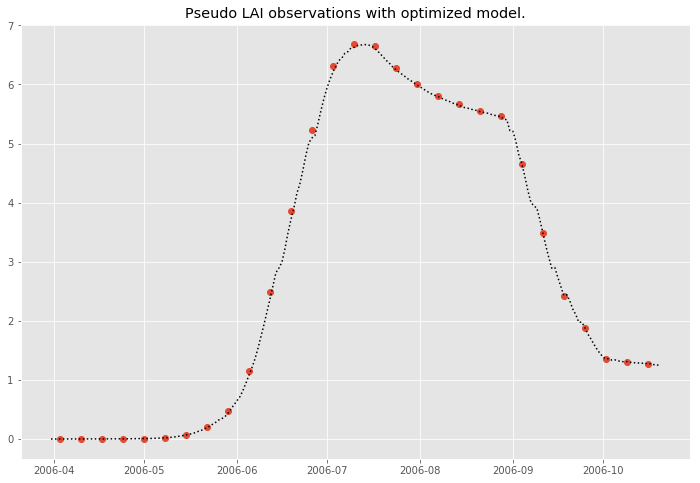

In [17]:
fig, axes = plt.subplots(figsize=(12,8))
axes.plot_date(df_pseudo_obs.index, df_pseudo_obs.LAI)
axes.plot_date(objfunc_calculator.df_simulations.index, objfunc_calculator.df_simulations.LAI, "k:")
axes.set_title("Pseudo LAI observations with optimized model.")